In [20]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import sys
from pathlib import Path
from pymatgen.core import Structure
from pymatgen.symmetry.kpath import KPathSeek

sys.path.append("../../../../../src/")
from wannier_utils.hamiltonian import HamK
from mag_rotation import MagRotation

In [21]:
struc = Structure.from_file('../../../FePt_sym.cif')
kpath = KPathSeek(struc)
kpath.kpath

{'kpoints': {'GAMMA': [0.0, 0.0, 0.0],
  'Z': [0.0, 0.0, 0.5],
  'M': [0.5, 0.5, 0.0],
  'A': [0.5, 0.5, 0.5],
  'R': [0.0, 0.5, 0.5],
  'X': [0.0, 0.5, 0.0]},
 'path': [['GAMMA', 'X', 'M', 'GAMMA', 'Z', 'R', 'A', 'Z'],
  ['X', 'R'],
  ['M', 'A']]}

In [ ]:
band_dft = pd.read_table("band.gnu", header=None, skip_blank_lines=False, delimiter="\s+")
E_F_scf = 16.9627
xticks = np.array([
    0.0000,
    0.5000,
    1.0000,
    1.7071,
    2.0681,
    2.5681,
    3.0681,
    3.7752,
])
plt.plot(band_dft.iloc[:,0]/xticks.max(), band_dft.iloc[:,1] - E_F_scf, color="grey")
plt.xlim(0,1)
plt.ylim(-5,9)
plt.xticks(xticks/xticks.max(), kpath.kpath["path"][0])
plt.ylabel("$E - E_F$ [eV]")
plt.grid()
#plt.savefig("band0.pdf")
plt.show()

In [ ]:
class Band():
    def __init__(self, 
                 band_dft, 
                 ham, kp_list, kp_label, E_F, 
                 ylim=[-5,5], 
                 spin_axis="x", 
                 file_name="band.pdf", 
                 kp_list_for_dft=[0],
                 ):
        self.num_wann = ham.num_wann
        self.E_F = E_F

        self.kp_list_all, self.l, self.tick_locs = self._make_kpath(kp_list)
        if kp_list_for_dft.any():
            kp_list_all, self.l, self.tick_locs = self._make_kpath(kp_list_for_dft)

        self.ek_all, self.vk_all = self._calc_band(ham, self.kp_list_all)
        self._spin_orbit_projection(spin_axis)
        self.plot_band(band_dft, kp_label, ylim, file_name)

    def _make_kpath(self, kp_list, mesh=30):
        kp_list_all = [kp_list[0]]
        l = [0]
        tick_locs = [0]
        for i in range(len(kp_list)-1):
            kp_list_all += [ (kp_list[i+1] - kp_list[i]) * float(j+1)/mesh + kp_list[i] for j in range(mesh) ]
            d = np.linalg.norm( kp_list[i+1] - kp_list[i] )
            l += [ d * float(j+1)/mesh + l[-1] for j in range(mesh) ]
            tick_locs.append( tick_locs[-1] + d )
        return kp_list_all, l, tick_locs

    def _calc_band(self, ham, kp_list_all):
        ek_all = np.zeros([self.num_wann, len(self.kp_list_all)])
        vk_all = np.zeros([self.num_wann, self.num_wann, len(self.kp_list_all)], dtype=complex)
        for ik, k in enumerate(kp_list_all):
            ham_k = HamK(ham, k, diagonalize=True)
            ek_all[:,ik] = ham_k.ek
            vk_all[:,:,ik] = ham_k.uk
        return ek_all, vk_all

    def _spin_orbit_projection(self, spin_axis):
        self.spin_orbit_projection = np.zeros([int(self.num_wann/2), self.num_wann, len(self.kp_list_all)])
        Sx,Sy,Sz = np.array([[0,1],[1,0]]), np.array([[0,-1j],[1j,0]]), np.array([[1,0],[0,-1]])
        
        for ik in range(len(self.kp_list_all)):
            for nw in range(self.num_wann):
                tmp = self.vk_all[:,nw,ik].reshape(int(self.num_wann/2), 2)
                if spin_axis == "x":
                    self.spin_orbit_projection[:,nw,ik] = np.einsum("ij,jl,il -> i", np.conjugate(tmp), Sx, tmp).real
                if spin_axis == "z":
                    self.spin_orbit_projection[:,nw,ik] = np.einsum("ij,jl,il -> i", np.conjugate(tmp), Sz, tmp).real
        
    def plot_band(self, band_dft, kp_label, ylim, file_name):     
        plt.figure()
        plt.rcParams["font.size"] = 16
        plt.rcParams['figure.subplot.left'] = 0.20
        plt.rcParams['figure.subplot.bottom'] = 0.20
        plt.plot(band_dft.iloc[:,0]/np.max(band_dft.iloc[:,0]), band_dft.iloc[:,1] - self.E_F, color="grey")
        for nw in range(self.num_wann):
            plt.scatter(self.l/max(self.tick_locs), self.ek_all[nw,:] - self.E_F, marker=".", lw=0, cmap="coolwarm", c=np.einsum("ij->j", self.spin_orbit_projection[:,nw,:]))
        plt.xlim([0, 1])
        
        plt.xticks(self.tick_locs/max(self.tick_locs), kp_label)
        plt.clim(-1, 1)
        # plt.colorbar(label="spin polarization")
        plt.ylim(ylim)
        plt.axhline(y=4, color="black", linestyle="--")
        plt.grid()
        plt.ylabel('$E - E_F$ [eV]')
        #plt.tight_layout()
        plt.savefig(file_name)
        plt.show()

In [23]:
ham = MagRotation( 
        tb_dat=Path("../wan/pwscf_py_tb.dat"), 
        extract_only_x_component=0,
        use_convert_ham_r=0,
        nnkp_file=Path("../wan/pwscf.nnkp"),
        win_file=Path("../wan/pwscf.win"),
    )

2023-09-15 19:01:21,623 [wannier_utils.hamiltonian INFO]: Reading ../wan/pwscf_py_tb.dat ...
2023-09-15 19:01:24,208 [wannier_utils.hamiltonian INFO]: Reading ../wan/pwscf_py_tb.dat is Done.
2023-09-15 19:01:24,209 [wannier_utils.hamiltonian DEBUG]: Wannier center from Amnrs:
2023-09-15 19:01:24,209 [wannier_utils.hamiltonian DEBUG]:   0      0.00000000     -0.00000000     -0.00000000
2023-09-15 19:01:24,209 [wannier_utils.hamiltonian DEBUG]:   1     -0.00000000      0.00000000     -0.00000000
2023-09-15 19:01:24,210 [wannier_utils.hamiltonian DEBUG]:   2     -0.00000000     -0.00000000     -0.00000000
2023-09-15 19:01:24,210 [wannier_utils.hamiltonian DEBUG]:   3      0.00000000      0.00000000      0.00000000
2023-09-15 19:01:24,210 [wannier_utils.hamiltonian DEBUG]:   4      0.00000000     -0.00000000      0.00000000
2023-09-15 19:01:24,210 [wannier_utils.hamiltonian DEBUG]:   5     -0.00000000      0.00000000     -0.00000000
2023-09-15 19:01:24,211 [wannier_utils.hamiltonian DEBUG]

In [ ]:
band_dft = pd.read_table("band.gnu", header=None, skip_blank_lines=False, delimiter="\s+")
E_F = 16.9627
struc = Structure.from_file('../../../FePt_sym.cif')
kpath = KPathSeek(struc)
kp_label = kpath.kpath["path"][0]

kp_list = []
for kl in kp_label:
    kp_list.append(np.array(kpath.kpath["kpoints"][kl]))

for i in range(len(kp_label)):
    if"GAMMA" in kp_label[i]:
        kp_label[i] = "$\Gamma$"

xticks = np.array([
    0.0000,
    0.5000,
    1.0000,
    1.7071,
    2.0681,
    2.5681,
    3.0681,
    3.7752,
])

kp_list_for_dft = np.array([
    [0.00, 0.00, 0.00],
    [0.00, 0.50, 0.00],
    [0.50, 0.50, 0.00],
    [0.00, 0.00, 0.00],
    [0.00, 0.00, 0.35],
    [0.00, 0.50, 0.35],
    [0.50, 0.50, 0.35],
    [0.00, 0.00, 0.35]
])

b = Band(band_dft, 
         ham, kp_list, kp_label, E_F, 
         ylim=[-5,9], 
         kp_list_for_dft=kp_list_for_dft, 
         )
print(b.tick_locs)

In [31]:
class Band():
    def __init__(self, 
                 band_dft, 
                 ham, kp_list, kp_label, E_F, 
                 ylim=[-5,5], 
                 spin_axis="x", 
                 file_name="band.pdf", 
                 kp_list_for_dft=[0],
                 ):
        self.num_wann = ham.num_wann
        self.E_F = E_F

        self.kp_list_all, self.l, self.tick_locs = self._make_kpath(kp_list)
        if kp_list_for_dft.any():
            kp_list_all, self.l, self.tick_locs = self._make_kpath(kp_list_for_dft)

        self.ek_all, self.vk_all = self._calc_band(ham, self.kp_list_all)
        self._spin_orbit_projection(spin_axis)
        self.plot_band(band_dft, kp_label, ylim, file_name)

    def _make_kpath(self, kp_list, mesh=30):
        kp_list_all = [kp_list[0]]
        l = [0]
        tick_locs = [0]
        for i in range(len(kp_list)-1):
            kp_list_all += [ (kp_list[i+1] - kp_list[i]) * float(j+1)/mesh + kp_list[i] for j in range(mesh) ]
            d = np.linalg.norm( kp_list[i+1] - kp_list[i] )
            l += [ d * float(j+1)/mesh + l[-1] for j in range(mesh) ]
            tick_locs.append( tick_locs[-1] + d )
        return kp_list_all, l, tick_locs

    def _calc_band(self, ham, kp_list_all):
        ek_all = np.zeros([self.num_wann, len(self.kp_list_all)])
        vk_all = np.zeros([self.num_wann, self.num_wann, len(self.kp_list_all)], dtype=complex)
        for ik, k in enumerate(kp_list_all):
            ham_k = HamK(ham, k, diagonalize=True)
            ek_all[:,ik] = ham_k.ek
            vk_all[:,:,ik] = ham_k.uk
        return ek_all, vk_all

    def _spin_orbit_projection(self, spin_axis):
        self.spin_orbit_projection = np.zeros([int(self.num_wann/2), self.num_wann, len(self.kp_list_all)])
        Sx,Sy,Sz = np.array([[0,1],[1,0]]), np.array([[0,-1j],[1j,0]]), np.array([[1,0],[0,-1]])
        
        for ik in range(len(self.kp_list_all)):
            for nw in range(self.num_wann):
                tmp = self.vk_all[:,nw,ik].reshape(int(self.num_wann/2), 2)
                if spin_axis == "x":
                    self.spin_orbit_projection[:,nw,ik] = np.einsum("ij,jl,il -> i", np.conjugate(tmp), Sx, tmp).real
                if spin_axis == "z":
                    self.spin_orbit_projection[:,nw,ik] = np.einsum("ij,jl,il -> i", np.conjugate(tmp), Sz, tmp).real
        
    def plot_band(self, band_dft, kp_label, ylim, file_name):     
        plt.figure()
        plt.rcParams["font.size"] = 16
        plt.rcParams['figure.subplot.left'] = 0.20
        plt.rcParams['figure.subplot.bottom'] = 0.20
        plt.plot(band_dft.iloc[:,0]/np.max(band_dft.iloc[:,0]), band_dft.iloc[:,1] - self.E_F, color="black")
        plt.plot(self.l/max(self.tick_locs), self.ek_all.T - self.E_F, linestyle="--", color="red")
        plt.xlim([0, 1])
        
        plt.xticks(self.tick_locs/max(self.tick_locs), kp_label)
       
        plt.ylim(ylim)
        plt.axhline(y=4, color="grey", linestyle="--")
        plt.grid()
        plt.ylabel('$E - E_F$ [eV]')
        plt.savefig(file_name)
        plt.show()

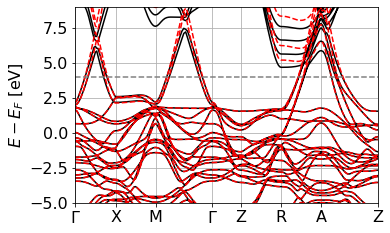

In [32]:
band_dft = pd.read_table("band.gnu", header=None, skip_blank_lines=False, delimiter="\s+")
E_F = 16.9627
struc = Structure.from_file('../../../FePt_sym.cif')
kpath = KPathSeek(struc)
kp_label = kpath.kpath["path"][0]

kp_list = []
for kl in kp_label:
    kp_list.append(np.array(kpath.kpath["kpoints"][kl]))

for i in range(len(kp_label)):
    if"GAMMA" in kp_label[i]:
        kp_label[i] = "$\Gamma$"

xticks = np.array([
    0.0000,
    0.5000,
    1.0000,
    1.7071,
    2.0681,
    2.5681,
    3.0681,
    3.7752,
])

kp_list_for_dft = np.array([
    [0.00, 0.00, 0.00],
    [0.00, 0.50, 0.00],
    [0.50, 0.50, 0.00],
    [0.00, 0.00, 0.00],
    [0.00, 0.00, 0.35],
    [0.00, 0.50, 0.35],
    [0.50, 0.50, 0.35],
    [0.00, 0.00, 0.35]
])

b = Band(band_dft, 
         ham, kp_list, kp_label, E_F, 
         ylim=[-5,9], 
         kp_list_for_dft=kp_list_for_dft, 
         )
